# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN](https://github.com/junyanz/CycleGAN)
* [A whole list](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes fake data to pass to the discriminator. The discriminator also sees real data and predicts if the data it's received is real or fake. The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real data. And the discriminator is trained to figure out which data is real and which is fake. What ends up happening is that the generator learns to make data that is indistiguishable from real data to the discriminator.

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector the generator uses to contruct it's fake images. As the generator learns through training, it figures out how to map these random vectors to recognizable images that can foold the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image. If you're interested only in generating new images, you can throw out the discriminator after training. Now, let's see how we build this thing in TensorFlow.

In [1]:
%matplotlib inline
import os
import time
import PIL
import glob
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten, Reshape,BatchNormalization
import matplotlib.pyplot as plt
from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')


## Generator network

![GAN Network](assets/gan_network.png)

Here we'll build the generator network. To make this network a universal function approximator, we'll need at least one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.

In [3]:
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(128, use_bias=False, input_shape=(100,)))
    model.add(LeakyReLU())
    model.add(Dense(784,  use_bias=False, activation='tanh'))
    model.add(Reshape((28,28)))
    return model


## Discriminator

The discriminator network is very similar to the generator with a few differences like the sigmoid output layer.

In [5]:
def make_discriminator_model():
    model = Sequential()
    model.add(Flatten(input_shape=[28,28,1]))
    model.add(Dense(256, activation=None))
    model.add(LeakyReLU())
    model.add(Dense(1, activation='sigmoid'))
    return model

## Hyperparameters

In [6]:
smooth = 0.1
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build network

Now we're building the network from the functions defined above.

First, we'll create the generator, `make_generator_model()`. This builds the generator with the appropriate input and output sizes.

Then the discriminators, `make_discriminator_model()`.

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for real and fake images, `total_loss = real_loss + fake_loss`. The losses will by binary cross-entropys, which we can get with `tf.keras.losses.BinaryCrossentropy(from_logits=True)`. We'll also wrap that in `tf.math.reduce_mean` to get the mean for all the images in the batch. So the losses will look something like 

```python
tf.math.reduce_mean(cross_entropy(labels, logits))
```

For the real image logits, we'll use `real_output` which we got from the discriminator. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as label smoothing, typically used with classifiers to improve performance. In TensorFlow, it looks something like `labels = tf.ones_like(real_output) * (1 - smooth)`

The discriminator loss for the fake data is similar. The logits are `fake_output`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

Finally, the generator losses are using `fake_output`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [9]:
# Calculate losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.math.reduce_mean(cross_entropy(tf.ones_like(real_output) * (1 - smooth), real_output))
    fake_loss = tf.math.reduce_mean(cross_entropy(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.math.reduce_mean(cross_entropy(tf.ones_like(fake_output), fake_output))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to build optimizers for the two parts.

In [10]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

## Training

In [11]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)


        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)
    
    
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(np.squeeze(predictions[i]) * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


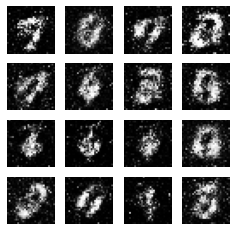

In [12]:
train(train_dataset, EPOCHS)

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at images taken while training.

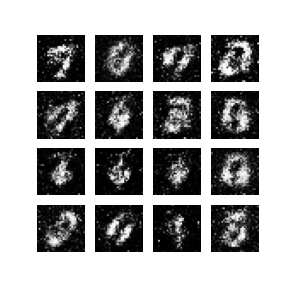

In [13]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('images/image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

These are samples from the final training epoch. You can see the generator is able to reproduce number like structures. Since this is just a sample, it isn't representative of the full range of images this generator can make.

Below I'm showing the generated images as the network was training.

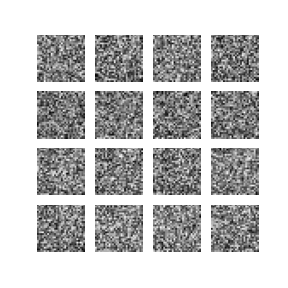

In [14]:
anim_file = 'images/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
#if IPython.version_info > (6,2,0,''):
display.Image(filename=anim_file)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator. We just need to pass in a new latent vector $z$ and we'll get new samples!

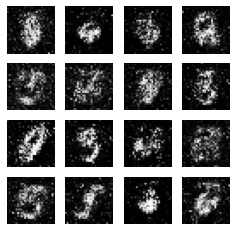

In [15]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(seed, training=False)
fig = plt.figure(figsize=(4,4))

for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.squeeze(generated_images[i]) * 127.5 + 127.5, cmap='gray')
        plt.axis('off')